In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
import matplotlib.pyplot as plt

# Importation des valeurs

In [3]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 

# Test du CIR 

In [21]:
import CIR

In [22]:
S = CIR.CIR(alpha, b, sigma, T, k, S_0)

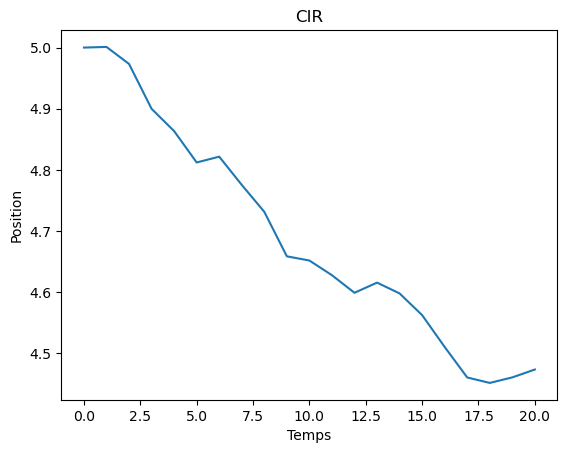

In [23]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR')
plt.show()

In [135]:
nb_samples = 100

In [136]:
M = CIR.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

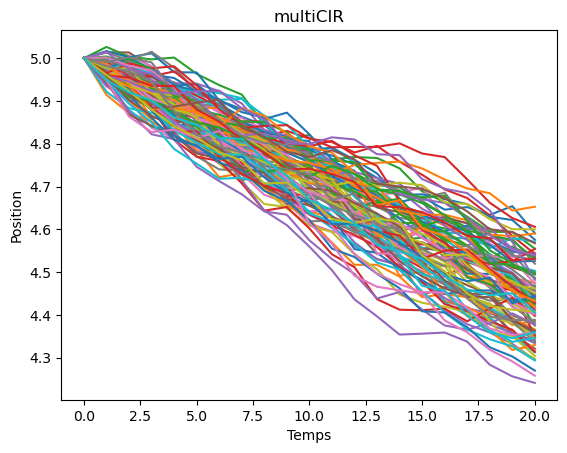

In [137]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# Monte Carlo Ordinaire

In [121]:
import ordinaryMC

In [122]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.73529732, 4.70677588, 4.63385372, 4.5602499 ,
       4.53454152, 4.51412171, 4.50117499, 4.50929502, 4.48580707,
       4.47465497, 4.42749264, 4.39655156, 4.38776246, 4.37460484,
       4.34704487, 4.33232278, 4.29669192, 4.26193682, 4.24910976,
       4.21798327])

In [123]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [124]:
np.mean(OMC)

0.6880460697046218

In [125]:
ordinaryMC.sim_iterator(1000, k, S_0, T, r, sigma, K, alpha, b)

array([0.67975599, 0.68021094, 0.68069495, 0.67429381, 0.67011416,
       0.67887001, 0.68215787, 0.67125641, 0.68612855, 0.67537753,
       0.67701416, 0.67579342, 0.67848094, 0.67336503, 0.68211486,
       0.68116737, 0.67139826, 0.68047821, 0.6785291 , 0.67426439,
       0.68325668, 0.67878214, 0.67409189, 0.67277726, 0.68517038,
       0.68035043, 0.67572811, 0.67604284, 0.67874997, 0.67553851,
       0.67510748, 0.6781814 , 0.68102559, 0.67355969, 0.67712003,
       0.68189176, 0.67918188, 0.68240722, 0.67972176, 0.6769394 ,
       0.68098152, 0.67691359, 0.67750305, 0.67859717, 0.67451382,
       0.67283607, 0.68147617, 0.67887281, 0.68218444, 0.67985445,
       0.67967286, 0.67745743, 0.68229004, 0.67740374, 0.6763977 ,
       0.67947026, 0.68080992, 0.67485455, 0.67392557, 0.67693718,
       0.6800317 , 0.67886813, 0.68151557, 0.67884413, 0.68121705,
       0.67694156, 0.67997767, 0.67979642, 0.68314159, 0.68239434,
       0.67963348, 0.67615952, 0.6818058 , 0.67937189, 0.67821

# Quasi Monte Carlo

# tests Sobol generator

In [126]:
nb_samples = 100

In [127]:
sobol = CIR.sobol_generator(nb_samples, k)
print(sobol, len(sobol), len(sobol[1,]))

[[0.5     0.75    0.25    ... 0.84375 0.34375 0.46875]
 [0.5     0.25    0.75    ... 0.21875 0.71875 0.09375]
 [0.5     0.75    0.25    ... 0.09375 0.59375 0.46875]
 ...
 [0.75    0.25    0.875   ... 0.53125 0.15625 0.65625]
 [0.75    0.25    0.375   ... 0.09375 0.21875 0.71875]
 [0.75    0.25    0.125   ... 0.78125 0.65625 0.15625]] 117 20


# tests CIR_QMC

In [138]:
M = CIR.multiCIR_QMC(alpha, b, sigma, T, k, S_0, nb_samples)

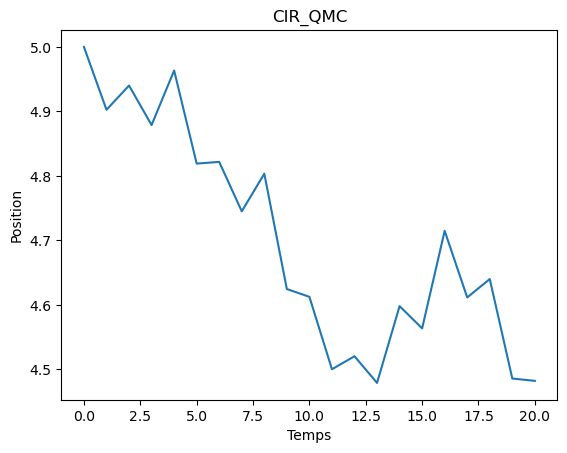

In [139]:
plt.plot(M[1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR_QMC')
plt.show()

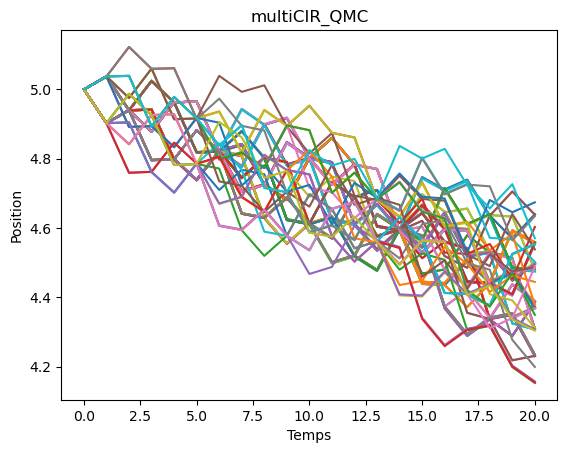

In [140]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR_QMC')
plt.show()

# Quasi Monte Carlos

In [88]:
import ordinaryMC
import QMC

In [89]:
ordinaryMC.pv_calc(M[3],r, T)

array([951.2294245 , 943.1949864 , 937.03166982, 928.47516088,
       921.94222047, 914.61279147, 909.27775056, 903.10816129,
       895.17913645, 890.47446414, 883.59828862, 877.18239487,
       868.62885086, 863.26170263, 856.16799231, 849.45113644,
       844.76289256, 837.15391531, 831.39003585, 824.43339882,
       819.22965607])

In [90]:
OMC_QMC = QMC.QMC_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)
np.mean(OMC_QMC)

879.3820289042992

In [91]:
QMC.sim_iterator_QMC(1000, k, S_0, T, r, sigma, K, alpha, b)

array([879.34467526, 879.32502293, 879.38080319, 879.39216619,
       879.38362216, 879.37165444, 879.39612341, 879.3885963 ,
       879.38260054, 879.3820289 , 879.37237787, 879.36592617,
       879.3613924 , 879.35798928, 879.37069069, 879.38022104,
       879.37714021, 879.35106692, 879.36452667, 879.36232593,
       879.37284502, 879.36765339, 879.36607723, 879.36702427,
       879.37002715, 879.37176241, 879.37825457, 879.36450932,
       879.36580068, 879.36726934, 879.36762781, 879.37416822,
       879.38152907, 879.391152  , 879.40502453, 879.41353313,
       879.43202648, 879.41565171, 879.42327128, 879.42492897,
       879.43089389, 879.43427734, 879.43378627, 879.43158072,
       879.43113541, 879.43029785, 879.4391675 , 879.43130717,
       879.43148563, 879.42682329, 879.42409148, 879.41690372,
       879.42134027, 879.41873111, 879.4189044 , 879.40766154,
       879.4137479 , 879.41714505, 879.409525  , 879.40715678,
       879.4063407 , 879.40898556, 879.4078221 , 879.39

# tests Multi Level CIR

In [4]:
import CIR

In [5]:
L = 3

In [6]:
S = CIR.level_CIR(alpha, b, sigma, L, T, S_0)

In [7]:
S

array([5.        , 4.89080936, 4.84387825, 4.78595392, 4.7371464 ,
       4.66091166, 4.60378181, 4.55947238, 4.50272535])

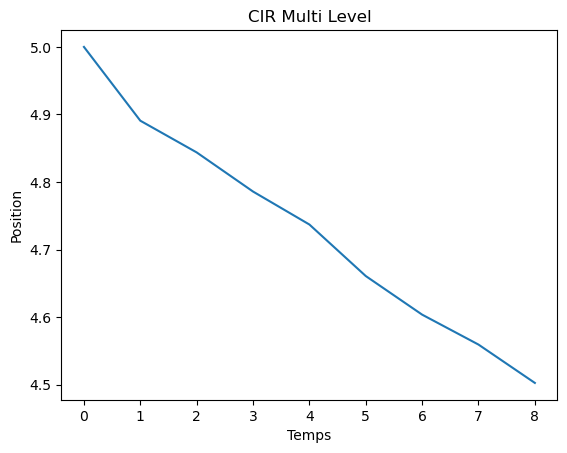

In [8]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [9]:
nb_samples = 100 

In [10]:
M = CIR.multiCIR_ML(alpha, b, sigma, L, T, S_0, nb_samples)

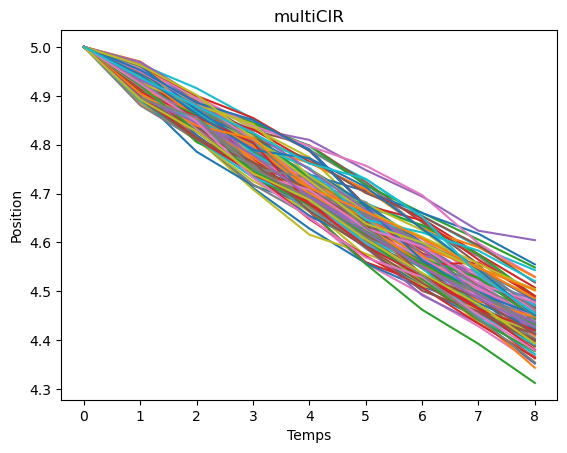

In [11]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

In [99]:
zap = CIR.CIR(alpha, b, sigma, T, k, S_0)
zap2 = CIR.CIR_ML(alpha, b, sigma, T, k, S_0,5)

In [100]:
zap

array([1000.        ,  992.24149871,  984.29460658,  976.4068157 ,
        969.7423737 ,  962.11966941,  955.15628873,  948.34192344,
        941.38141745,  934.27450366,  927.43665843,  920.86286667,
        913.99932066,  907.45439369,  900.39086413,  893.23754233,
        886.9179914 ,  880.09466744,  872.84344813,  866.017522  ,
        859.98945129])

In [101]:
zap2

array([1000.        ,  990.46117392,  981.39982838,  971.68914217,
        962.85992471,  953.91998516,  944.74041551,  935.56966166,
        926.50960883,  917.71959879,  908.92410262,  900.20829462,
        891.47485445,  882.91834458,  875.56105974,  867.225721  ,
        859.17785251,  851.25730492,  843.06987932,  835.17311589,
        827.94049722])

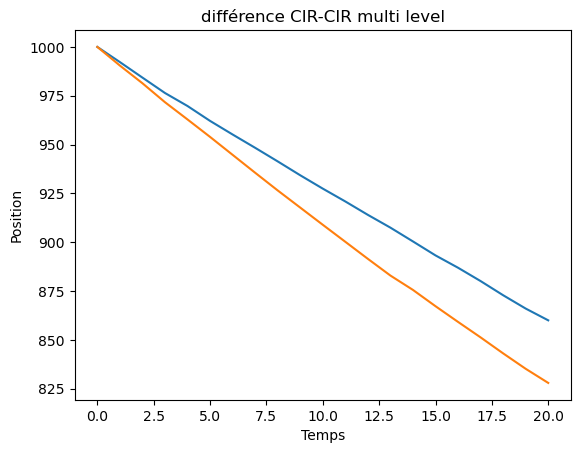

In [102]:
plt.plot(zap)
plt.plot(zap2)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('différence CIR-CIR multi level')
plt.show()

# Multi Level Monte Carlo

In [103]:
import MLMC

In [104]:
variance = np.full(14, 1)  
k = 20
T = 1
l = 0
L = 0
epsilon = np.exp(-1)

In [105]:
CIR.CIR_ML(alpha, b, sigma, T, k, S_0, L)

array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.])

In [106]:
MLMC.N_l(variance, k, T,l, L, epsilon)

0
0.0


0

In [107]:
MLMC_test = MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b)

0
0.0
3.909154365220587
225.83154201415252
16.025630586560702
143.47638493840532


IndexError: index 2 is out of bounds for axis 0 with size 2